# 1.- Información mutua

In [1]:
#Importamos las librerias necesarias
import cv2
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.colors as colors
import matplotlib.cbook as cbook
import scipy
from scipy import ndimage
from scipy import optimize
import time 


Aquí, se que ya existen funciones para calcular el histograma, pero preferí implementarlos tomando en cuenta que son funciones bastante cortas

In [23]:
#Si la imagen 1 es de tamaño n1xm1 y la imagen 2 es de tamaño n2xm2 el algoritmo es O(n*m) donde n = min(n1,n2) m = min(n2,m2)
def jointHist(img1,img2):
    #El tamaño de la primera imagen 
    n1 = img1.shape[0]
    m1 = img1.shape[1]
    #El tamaño de la segunda imagen 
    n2 = img2.shape[0]
    m2 = img2.shape[1]
    #Ahora vamos a romar la menor de los anchos y alturas
    n = np.min([n1,n2])
    m = np.min([m1,m2])
    #Inicializamos lo que sería el histograma conjunto
    hist = np.zeros((256,256))
    for i in range(0,n):
        for j in range(0,m):
            value1 = img1[i,j]
            value2 = img2[i,j]
            hist[value1,value2] += 1
    return hist

def singleHist(img):
    n = img.shape[0]
    m = img.shape[0]
    hist = np.zeros((256))
    for i in range(0,n):
        for j in range(0,m):
            value = img[i,j]
            hist[value] +=1
    return hist

<Figure size 432x288 with 0 Axes>

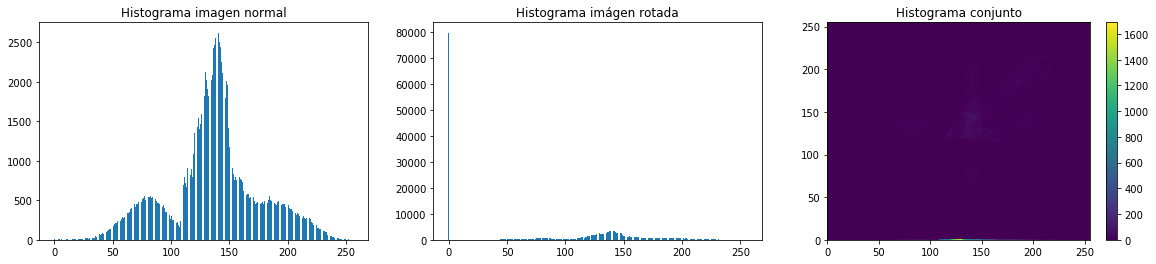

In [24]:
#Vamos a abrir las dos imágenes que nos dan a alinear
img1 = cv2.imread('I_despla.png',0)
img2 = cv2.imread('I_fija.png',0)

#Obtenemos sus histogramas individuales
hist1 = singleHist(img1)
hist2 = singleHist(img2)

#Obtenemos el histograma conjunto delas imagenes
joint = jointHist(img1, img2)
x = np.linspace(0,255,256)
#Vamos a
plt.figure()
fig, ax = plt.subplots(1,3,figsize=(20, 4))
ax[0].bar(x,hist2,align = 'edge')
ax[0].set_title('Histograma imagen normal')
ax[1].bar(x,hist1)
ax[1].set_title('Histograma imágen rotada')
cm =ax[2].pcolormesh(x,x,joint)
ax[2].set_title("Histograma conjunto")
fig.colorbar(cm,ax = ax[2])

Vamos a programar una función para obtener la información mutua entre las dos imágenes. Usaremos la ecuación que se vió en clase que es la siguiente:

\begin{equation}
I = \sum_{x,y} P_{XY}(x,y) \log{\frac{P_{XY} (x,y)}{P_{X}(x)P_{Y}(y)}}
\end{equation}

Según lo que vimos en clase cuando $X$ y $Y$ son variables independientes (que sería el caso en que no hay empalme) entonces se tiene 
\begin{equation}
P_{XY}(x,y) = P_{X}(x) P_{Y}(y)
\end{equation}


Por lo cual se tendría:

\begin{equation}
I = \sum_{x,y} P_{XY}(x,y) \log{\frac{P_{X}(x) P_{Y}(y)}{P_{X}(x)P_{Y}(y)}} = \sum_{XY} P_{XY}(x,y) \log{1} = 0
\end{equation}



In [25]:
#Ahora vamos a programar una función para información mutua
#La función recibe dos histogramas, un histograma conjunto y en base a ello 
#determina la información mutua entre las dos imágenes
def mutualInformation(hist1,hist2, joint):
    prob1 = hist1/sum(hist1)
    prob2 = hist2/sum(hist2)
    jointProb = joint/sum(sum(joint))
    
    info = 0
    [n,m] = jointProb.shape
    
    for i in range(0,n):
        for j in range(0,m):
            if(prob1[i] != 0 and prob2[j] != 0 and jointProb[i,j] != 0):
                info = info + jointProb[i,j]*np.log(jointProb[i,j]/(prob1[i]*prob2[j]))
            
    return info

def imMutualInformation(img1,img2):
    hist1 = singleHist(img1)
    hist2 = singleHist(img2)
    joint = jointHist(img1,img2)
    return mutualInformation(hist1,hist2,joint)

Probemos obtener la información mutua de las imagenes original y rotada:

In [26]:
mutualInformation(hist1,hist2,joint)

0.48722694855761356

Ahora queda obtener la matriz de transformación que empalme las imágenes usando está medida información mutua. 

La matriz como tal consta de una rotación a un ángulo $\theta$ y una traslación a un nuevo punto $(t_{x},t_{y})$, la transformación resultante sería de la siguiente forma:

\begin{equation}
R(\theta) = \begin{pmatrix}
\cos{\theta} & -\sin{\theta} & t_{x}\\
\sin{\theta} & \cos{\theta} & t_{y}\\
0 & 0 & 1
\end{pmatrix}
\end{equation}


In [27]:
#La función a minimizar es 
def matchTransRotation(img, target, theta,tx,ty):
    transformationMat = np.float32([[np.cos(theta),-np.sin(theta),tx],[np.sin(theta),np.cos(theta),ty]])
    rows,cols = img.shape
    transformedImg = cv2.warpAffine(img,transformationMat,(cols,rows))
    info = -imMutualInformation(transformedImg,target)
    return info




In [28]:
matchTransRotation(img2,img1,10,10,10)

-0.05426556854617106

In [29]:
#Ahora sí hacemos la minimización 
#Esto tarda un poco en correr, hay que tener paciencia 
t0 = time.process_time()
optimization  = scipy.optimize.fmin_powell(lambda a: matchTransRotation(img1,img2,a[0],a[1],a[2]), [0,0,-140])
t1 = time.process_time()
print("Tiempo que tomó la optimización "+str(t1-t0)+" s")
transfMat = np.float32([[np.cos(optimization[0]),-np.sin(optimization[0]),optimization[1]],[np.sin(optimization[0]),np.cos(optimization[0]),optimization[2]]])
[rows,cols] = img1.shape
repositionedImage = cv2.warpAffine(img1,transfMat,(cols,rows))

Optimization terminated successfully.
         Current function value: -3.277592
         Iterations: 8
         Function evaluations: 489
Tiempo que tomó la optimización 254.40625 s


In [30]:
optimization

array([   0.26186822,   31.0331318 , -143.8599132 ])

Text(0.5, 1.0, 'Usando la matriz de transformación encontrada')

<Figure size 432x288 with 0 Axes>

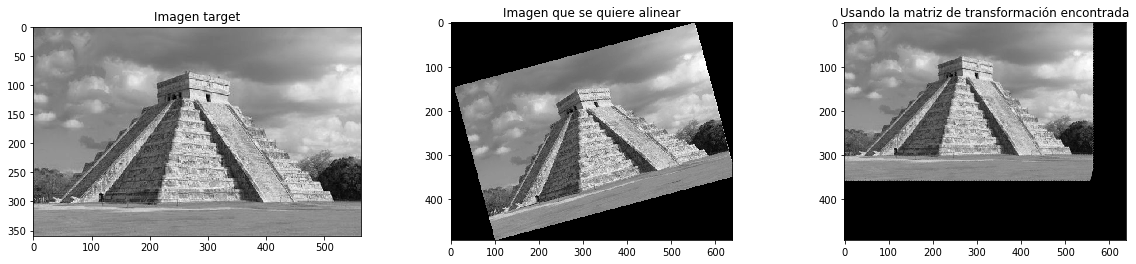

In [31]:
plt.figure()
fig, ax = plt.subplots(1,3,figsize=(20, 4))
ax[0].imshow(img2,cmap = 'gray')
ax[0].set_title('Imagen target')
ax[1].imshow(img1,cmap= 'gray')
ax[1].set_title('Imagen que se quiere alinear')
ax[2].imshow(repositionedImage,cmap = 'gray')
ax[2].set_title("Usando la matriz de transformación encontrada")

Vemos que funciona bastante bien

In [32]:
print("La matriz es " + str(transfMat))

La matriz es [[   0.965908     -0.25888553   31.033133  ]
 [   0.25888553    0.965908   -143.85991   ]]


# 2.- RANSAC (Este fué en equipo pero lo agrego para tener completos los métodos implementados para la tarea)

Lo primero que se hizo fue esta clase, en la cual encapsulamos métodos para abrir convenientemente la nube de puntos, para visualizarlos y para transformarlos dada una matriz $M$

In [43]:
import open3d as o3d
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
class PointCloudHandler:
    
    def __init__(self,path):
        #Leemos la nuve de puntos 
        if(path != ""):
            self.pc = o3d.io.read_point_cloud(path)
        else:
            self.pc = o3d.geometry.PointCloud()
    
    #Método para obtener los puntos en forma de arreglo
    def getCloudPointArray(self):
        return np.asarray(self.pc.points)
    
    #Método para graficar la nube de puntos
    def plotPointCloud(self,name):
        points = self.getCloudPointArray()
        #Obtenemos el promedio en la coordenada z, para que haya un gradiente de color
        meanZ = np.mean(points, axis = 0)[2]
        spatialQuery = points[np.abs(points[:,2] - meanZ) < 1]
        xyz=spatialQuery[:,:3]
        rgb = spatialQuery[:,:3]
        rgb = rgb + np.abs(np.min(rgb))
        rgb = rgb*255/np.max(rgb)
        #Create a 3d space
        ax = plt.axes(projection = '3d')
        ax.set_title(name)
        ax.view_init(elev=100, azim=-90)
        ax.scatter(xyz[:,0],xyz[:,1],xyz[:,2], c = rgb/255.0, s = 0.005)
        plt.show()

    #Método para transformar los puntos usando una matriz M 
    def transformPoints(self, M):
        points = self.getCloudPointArray()
        [n,m] = points.shape
        newPoints = np.zeros((n,3))
        for i in range(0,n):
            newPoints[i,:] = M.dot(points[i,:])
        
        self.setPoints(newPoints)
        
    def setPoints(self,points):
        self.pc.points = o3d.utility.Vector3dVector(points)
        

In [44]:
a = o3d.io.read_point_cloud("dragon_fijo.ply")
b = np.asarray(a.points)

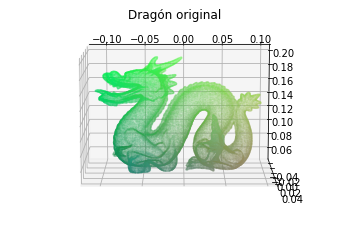

In [45]:
#Abrimos nuestro dragón original
handler = PointCloudHandler("dragon_fijo.ply")
handler.plotPointCloud("Dragón original")

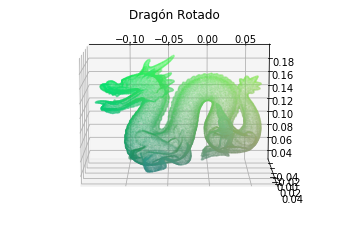

In [46]:
#Abrimos el dragon rotado
handlerRot = PointCloudHandler("dragon_des.ply")
handlerRot.plotPointCloud("Dragón Rotado")

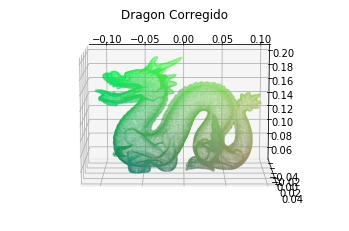

La matriz de transformación es [[ 9.78147596e-01  2.07911685e-01  1.88369656e-08]
 [-2.07911661e-01  9.78147585e-01  3.09987760e-08]
 [-1.56777427e-12 -3.93789260e-13  1.00000000e+00]]


In [47]:
#Vamos a usar RANSAC para obtener una matriz de transformación 
M, mask = cv2.findHomography(handlerRot.getCloudPointArray(), handler.getCloudPointArray(), cv2.RANSAC,5.0)
handlerRot.transformPoints(M)

handlerRot.plotPointCloud("Dragon Corregido")
print("La matriz de transformación es "+str(M))

# 3.- Conteo de arroz en una imagen 

In [1026]:
class RiceCounter:
        
    def applyOtsuThresholding(self,img):
        ret,th = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        return th
    #Aplica el filtro homomorfico
    def applyHomomorphicFilter(self,img,filterParams):
        #Lo primero que necesitamos es obtener la DFT
        [n,m] = img.shape
        dftN = cv2.getOptimalDFTSize(n)
        dftM = cv2.getOptimalDFTSize(m)
        #Parámetros del filtro (vease el texto de abajo)
        gammaH = filterParams[0]
        gammaL = filterParams[1]
        c = filterParams[2]
        d0 = filterParams[3]
        #Hacemos un padding necesario para hacer el filtrado en el dominio 
        #de la frecuencia
        padded = cv2.copyMakeBorder(img, 0, dftN - n, 0, dftM - m, cv2.BORDER_CONSTANT, 0)
        padded = np.log(padded + 1)
        transf = cv2.dft(np.float32(padded)/255.0, flags = cv2.DFT_COMPLEX_OUTPUT)
        transf = np.fft.fftshift(transf)
        du = np.zeros(transf.shape, dtype = np.float32)
        #img = 20 * np.log(cv2.magnitude(transf[:,:,0], transf[:,:,1]))
        for u in range(dftN):
            for v in range(dftM):
                du[u,v] = np.sqrt((u-dftN/2.0)*(u-dftN/2.0) + (v - dftM/2.0)*(v - dftM/2.0))
        
        du2 = cv2.multiply(du,du)/(2*d0*d0)
        re = np.exp(-c*du2)
        H = gammaL + (gammaH - gammaL)*(1-re)
        filtered = cv2.mulSpectrums(transf,H,0)
        img = 20 * np.log(cv2.magnitude(filtered[:,:,0], filtered[:,:,1]))
        #Obtenemos la inversa 
        filtered = np.fft.ifftshift(filtered)
        filtered = cv2.idft(filtered)
        #Normalización 
        filtered = cv2.magnitude(filtered[:,:,0],filtered[:,:,1])
        cv2.normalize(filtered,filtered, 0, 1, cv2.NORM_MINMAX)
        filtered = np.exp(filtered)
        cv2.normalize(filtered,filtered,0, 1, cv2.NORM_MINMAX)
        filtered = filtered*255.0
        filtered = filtered.astype(np.uint8)
        filtered = filtered[0:n,0:m]
        return filtered
    
    def cleanImage(self,img):
        kernel = np.ones((5,5),np.uint8)
        erosion = cv2.erode(img,kernel,iterations = 1)
        return erosion
    
    
    
    def countRice(self, img):
            fp = [100,50,1,1]
            imFilt = self.applyHomomorphicFilter(img,fp)
            th = self.applyOtsuThresholding(imFilt)
            cln = self.cleanImage(th)
            connectivity = 4
            ret, labels = cv2.connectedComponents(cln, connectivity=4)
            return ret
    


        
    
        
        


#Abrimos la imagen del arroz


Text(0.5, 1.0, 'Imagen arroz segmentada sin filtro para luminosidad')

<Figure size 432x288 with 0 Axes>

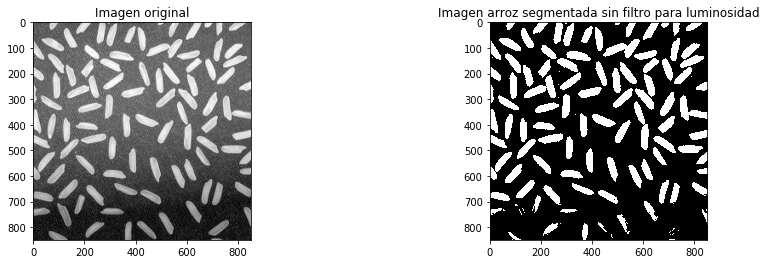

In [1027]:
#Abrimos la imagen
riceImage = cv2.imread('rice.jpg',0)
#Vamos a aplicar un thresholding de Otsu inocentemente sin considerar los cambios en luminosidad
counter = RiceCounter()
threshImg = counter.applyOtsuThresholding(riceImage)
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(15, 4))
ax[0].imshow(riceImage,cmap = 'gray')
ax[0].set_title('Imagen original')
ax[1].imshow(threshImg,cmap= 'gray')
ax[1].set_title('Imagen arroz segmentada sin filtro para luminosidad')



Sobre todo en la parte inferior vemos que algunos granos de arroz quedan bastante borrosos si no corregimos primero la imagen por luminosidad. Siguiendo el consejo que nos dió el profesor vamos a utilizar un filtro homomorfico, a ver si el resultado es mejor.
Estos filtros tienen la siguiente forma:

\begin{equation}

\end{equation}

Text(0.5, 1.0, 'Imagen filtrada con filtro homomórfico')

<Figure size 432x288 with 0 Axes>

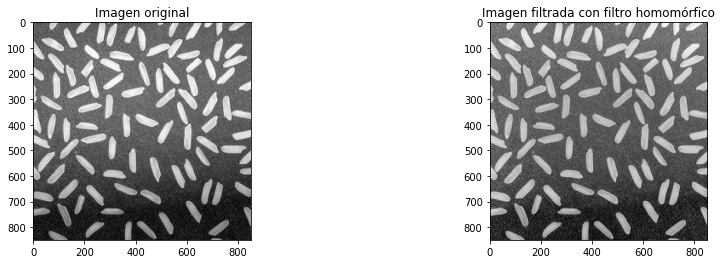

In [1028]:
#Probemos el filtro homomorfico
filterParams = [100,50,1,1]
filteredImg = counter.applyHomomorphicFilter(riceImage, filterParams)
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(15, 4))
ax[0].imshow(riceImage,cmap = 'gray')
ax[0].set_title('Imagen original')
ax[1].imshow(filteredImg,cmap= 'gray')
ax[1].set_title('Imagen filtrada con filtro homomórfico')

Probemos la segmentación ahora

Text(0.5, 1.0, 'Imagen arroz segmentada despues de filtro')

<Figure size 432x288 with 0 Axes>

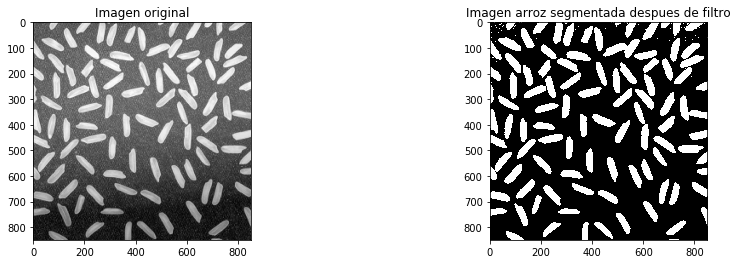

In [1029]:
threshImg = counter.applyOtsuThresholding(filteredImg)
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(15, 4))
ax[0].imshow(riceImage,cmap = 'gray')
ax[0].set_title('Imagen original')
ax[1].imshow(threshImg,cmap= 'gray')
ax[1].set_title('Imagen arroz segmentada despues de filtro')

Vamos a limpiar un poco la imagen, en particular nos gustaria remover puntos que quedan solos en la imagen

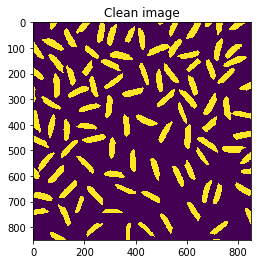

In [1030]:
cleaned = counter.cleanImage(threshImg)
plt.title("Clean image")
plt.imshow(cleaned)

In [1031]:
#Finalmente hacemos el conteo 
print("El número de granos de arroz es "+str(counter.countRice(riceImage)))

El número de granos de arroz es 106
